## imports

In [137]:
import os
import numpy as np
import random
import copy
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ast
from scipy import constants
from vivarium.core.process import Process, Step
from vivarium.core.composer import Composer
from vivarium.core.engine import Engine
from vivarium.library.units import units, remove_units

## SimpleCell Process

In [138]:
class SimpleCell(Process):
    """
    Simple Cell
    ===========

    A simple cell model with HIF, lactate, and GFP, following this system of equations:
        dHIF = ksxs + ksx*(HIF^2)/(kpx + HIF^2) - kdx*HIF - kdsx*HIF*lactate
        dlactate = ksy*HIF^2/(kpy + HIF^2) - kdy*lactate
        dGFP = Vg*HIF^3/(kg+HIF^3) - dg*GFP

    Latex equations:
        \frac{dHIF}{dt} = k_{sxs} + \frac{k_{sx}HIF^2}{k_{px} + HIF^2} - k_{dx}HIF - k_{dsx}HIF*lactate
        \frac{dlactate}{dt} = \frac{k_{sy}HIF^2}{k_{py} + HIF^2} - k_{dy}lactate
        \frac{dGFP}{dt} = \frac{V_gHIF^3}{k_g+HIF^3} - d_gGFP

    """

    defaults = {
        'k_HIF_production_basal': 0.02,  # k_sxs
        'k_HIF_production_max': 0.9,  # k_sx
        'k_HIF_pos_feedback': 1,  # k_px
        'k_HIF_deg_basal': 0.2,  # k_dx
        'k_HIF_deg_lactate': 1,  # k_dsx
        'k_lactate_production': 0.01,  # 0.01 k_sy
        'k_lactate_production_reg': 1,  # k_py
        'k_lactate_deg_basal': 0.01,  # k_dy
        'k_GFP_production_constantFP_production': 1,  # V_g
        'k_GFP_production_constant': 0.05,  # k_g
        'k_GFP_deg': 0.1,  # d_g

        # initial states
        'HIF_initial': 0.1,  #
        'lactate_initial': 0.001,  #
        'external_lactate_initial': 0.1,
        'GFP_initial': 0.0,  #

        # TODO transport
        'k_MCT1': 1E-3,  # 1E-3 lactate import
        'k_MCT4': 1E-3,  # 1E-3 lactate export

        # oxygen consumption
        'external_oxygen_initial': 1.1,

        # oxygen exchange
        'o2_response_scaling': 1.0,
        'kmax_o2_deg': 1e-1,
        'k_min_o2_deg': 1e-2
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.internal_species_list = ['HIF', 'lactate', 'GFP', 'oxygen']
        self.external_species_list = ['lactate', 'oxygen']

        self.conc_conversion = {
            'oxygen': 1.0,
            'lactate': 10.0,
        }  # TODO set conversion from conc to counts

    def initial_state(self, config=None):
        return {
            'internal_species': {
                'HIF': config.get('HIF_initial') or self.parameters['HIF_initial'],
                'lactate': config.get('lactate_initial') or self.parameters['lactate_initial'],
                'GFP': config.get('GFP_initial') or self.parameters['GFP_initial'],
            },
            'boundary': {
                'external': {
                    'lactate': config.get('external_lactate_initial') or self.parameters['external_lactate_initial'],
                    'oxygen': config.get('external_oxygen_initial') or self.parameters['external_oxygen_initial'],
                }
            }
        }
    
    def ports_schema(self):
        return {
            'internal_species': {
                species_id: {
                    '_default': 0.0,
                    '_emit': True,
                } for species_id in self.internal_species_list
            },
            'boundary': {
                # external is how the cell sees its surroundings
                'external': {
                    species_id: {
                        '_default': 0.0,
                        '_emit': True,
                    } for species_id in self.external_species_list
                },
                # exchange is how the cell updates its surroundings
                'exchange': {
                    species_id: {
                        '_default': 0.0,
                        '_emit': True,
                    } for species_id in self.external_species_list
                }
            }
        }

    def next_update(self, interval, states):

        # get the variables
        hif_in = states['internal_species']['HIF']
        oxygen_ex = states['boundary']['external']['oxygen']
        lactate_in = states['internal_species']['lactate']
        lactate_ex = states['boundary']['external']['lactate']
        gfp_in = states['internal_species']['GFP']

        # Calculate the rate of change of HIF
        hif_production = (
                self.parameters['k_HIF_production_basal'] +
                self.parameters['k_HIF_production_max'] * hif_in ** 2 /
                (self.parameters['k_HIF_pos_feedback'] + hif_in ** 2)
        )
        hif_degradation = (
                self.parameters['k_HIF_deg_basal'] * hif_in * oxygen_ex +
                self.parameters['k_HIF_deg_lactate'] * hif_in * lactate_in
        )
        dHIF = hif_production - hif_degradation

        # Calculate the rate of change of Lactate
        lactate_production = (
                self.parameters['k_lactate_production'] * hif_in ** 2 /
                (self.parameters['k_lactate_production_reg'] + hif_in ** 2)
        )
        lactate_degradation = self.parameters['k_lactate_deg_basal'] * lactate_in
        lactate_transport = (  # TODO: improve function for lactate transport
                self.parameters['k_MCT1'] * lactate_ex -
                self.parameters['k_MCT4'] * lactate_in
        )
        dLactate = lactate_production - lactate_degradation + lactate_transport

        # Calculate the rate of change of GFP
        gfp_production = (
                self.parameters['k_GFP_production_constantFP_production'] * hif_in ** 3 /
                (self.parameters['k_GFP_production_constant'] + hif_in ** 3)
        )
        gfp_degradation = self.parameters['k_GFP_deg'] * gfp_in
        dGFP = gfp_production - gfp_degradation

        # Calculate oxygen exchange
        dO2_ext = 0
        if oxygen_ex > 0:
            dO2_ext = - self.parameters['o2_response_scaling'] * (self.parameters['k_min_o2_deg'] + self.parameters['kmax_o2_deg'] / (hif_in + 1))
            # dO2_ext = - self.parameters['k_min_o2_deg'] - self.parameters['kmax_o2_deg'] / (
            #         (hif_in / self.parameters['HIF_threshold'])**self.parameters['hill_coeff_o2_deg'] + 1)

        # convert dO2 and lactate transport from concentration to counts
        # TODO -- these should be ints
        dO2_ext *= self.conc_conversion['oxygen']
        dLactate_ext = - lactate_transport * self.conc_conversion['lactate']

        # retrieve the results
        return {
            'internal_species': {
                'HIF': dHIF * interval,
                'lactate': dLactate * interval,
                'GFP': dGFP * interval,
            },
            'boundary': {
                'exchange': {
                    'oxygen': dO2_ext*interval,
                    'lactate': dLactate_ext*interval,
                }
            }
        }

## LocalField Step

In [139]:
CONCENTRATION_UNIT = units.ng / units.mL  # (units.mmol / units.L) concentration would not use molecular_weight
AVOGADRO = constants.N_A
MOLECULAR_WEIGHTS = {
    'HIF': 93000 * units.g / units.mol,
    'lactate': 90.08 * units.g / units.mol,
    'GFP': 27000 * units.g / units.mol,
    'oxygen': 31.999 * units.g / units.mol,
}


class LocalField(Step):
    """Take exchanges and apply them to a field at the cell's location"""

    name = 'local_field'
    defaults = {
        'molecular_weight': MOLECULAR_WEIGHTS,
        'concentration_unit': CONCENTRATION_UNIT
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.conc_conversion = {}
        for mol_id, mw in self.parameters['molecular_weight'].items():
            self.conc_conversion[mol_id] = (units.mol / units.L * mw).to(
                self.parameters['concentration_unit']).magnitude

    def ports_schema(self):
         return {
            'exchanges': {
                '*': {'_default': 0}
            },
            'location': {
                '_default': [0.5, 0.5]
            },
            'fields': {
                '*': {'_default': np.ones(1)}
            },
            'dimensions': {
                'bounds': {'_default': [1, 1]},
                'n_bins': {'_default': [1, 1]},
                'depth': {'_default': 1},
            }
        }

    def next_update(self, timestep, states):
        if not states:
            return {}
        location = remove_units(states['location'])
        n_bins = states['dimensions']['n_bins']
        bounds = states['dimensions']['bounds']
        depth = states['dimensions']['depth']
        exchanges = states['exchanges']

        # get bin
        bin_site = get_bin_site(location, n_bins, bounds)
        bin_volume_liters = get_bin_volume(n_bins, bounds, depth)

        # apply exchanges
        delta_fields = {}
        reset_exchanges = {}
        for mol_id, counts in exchanges.items():
            delta_fields[mol_id] = np.zeros(
                (n_bins[0], n_bins[1]), dtype=np.float64)
            concentration = counts / (bin_volume_liters * AVOGADRO) * self.conc_conversion[mol_id]
            delta_fields[mol_id][bin_site[0], bin_site[1]] += concentration
            reset_exchanges[mol_id] = {
                '_value': 0,
                '_updater': 'set'}

        return {
            'exchanges': reset_exchanges,
            'fields': delta_fields}

## CompositeCell

In [140]:
class CompositeCell(Composer):
    defaults = {
        'parallel': False,
        'cell_id': None,
        'cell_config': {},
        'boundary_path': ('boundary',),
        'field_path': ('..', '..', 'fields',),
        'dimensions_path': ('..', '..', 'dimensions',),
    }

    def __init__(self, config):
        super().__init__(config)

    def generate_processes(self, config):
        if self.config['parallel']:
            config['cell_config']['_parallel'] = True
        cell_process = SimpleCell(config['cell_config'])
        local_field = LocalField()
        return {
            'cell_process': cell_process,
            'local_field': local_field,
        }

    def generate_topology(self, config):
        boundary_path = config['boundary_path']
        field_path = config['field_path']
        dimensions_path = config['dimensions_path']

        return {
            'cell_process': {
                'internal_species': ('internal_store',),
                'boundary': ('boundary',),
            },
            'local_field': {
                'exchanges': boundary_path + ('exchange',),
                'location': boundary_path + ('location',),
                'fields': field_path,
                'dimensions': dimensions_path,
            },
        }

## DiffusionField Process

In [141]:
def get_bin_site(location, n_bins, bounds):
    bin_site_no_rounding = np.array([
        location[0] * n_bins[0] / bounds[0],
        location[1] * n_bins[1] / bounds[1]
    ])
    bin_site = tuple(
        np.floor(bin_site_no_rounding).astype(int) % n_bins)
    return bin_site


def get_bin_volume(n_bins, bounds, depth):
    total_volume = (depth * bounds[0] * bounds[1]) * 1e-15  # (L)
    return total_volume / (n_bins[0] * n_bins[1])
    

# laplacian kernel for diffusion
LAPLACIAN_2D = np.array([[0.0, 1.0, 0.0], [1.0, -4.0, 1.0], [0.0, 1.0, 0.0]])


class DiffusionField(Process):

    defaults = {
        # lattice dimensions
        'bounds': [10, 10],
        'bin_size': 1,
        'depth': 1.0,

        # molecules
        'molecules': [
            'lactate',
            'oxygen',
        ],

        # diffusion
        'default_diffusion_dt': 0.001,
        'default_diffusion_rate': 1e-1,

        # specific diffusion rates
        'diffusion': {
            'lactate': 1E-1,  # units.cm * units.cm / units.day,
            'oxygen': 1E0,  # units.cm * units.cm / units.day,
        },

        # edge clamp
        'clamp_edges': False,  # a dict with {'field_id': clamp_value}
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

        # parameters
        self.molecule_ids = self.parameters['molecules']
        self.bounds = [b for b in self.parameters['bounds']]
        self.n_bins = [
            int(self.bounds[0] / self.parameters['bin_size']),
            int(self.bounds[1] / self.parameters['bin_size'])
        ]
        self.depth = self.parameters['depth']

        # get diffusion rates
        diffusion_rate = self.parameters['default_diffusion_rate']
        bins_x = self.n_bins[0]
        bins_y = self.n_bins[1]
        length_x = self.bounds[0]
        length_y = self.bounds[1]
        dx = length_x / bins_x
        dy = length_y / bins_y
        dx2 = dx * dy

        # general diffusion rate
        self.diffusion_rate = diffusion_rate / dx2

        # diffusion rates for each individual molecules
        self.molecule_specific_diffusion = {
            mol_id: diff_rate/dx2
            for mol_id, diff_rate in self.parameters['diffusion'].items()}

        # get diffusion timestep
        diffusion_dt = 0.5 * dx ** 2 * dy ** 2 / (2 * diffusion_rate * (dx ** 2 + dy ** 2))
        self.diffusion_dt = min(diffusion_dt, self.parameters['default_diffusion_dt'])

        # get bin volume, to convert between counts and concentration
        self.bin_volume = get_bin_volume([bins_x, bins_y], self.bounds, self.depth)

        # check that edge clamp are all in dict
        if isinstance(self.parameters['clamp_edges'], dict):
            for key in self.parameters['clamp_edges'].keys():
                assert key in self.molecule_ids, f'clamp edge key {key} not in molecules'


    def initial_state(self, config=None):
        """get initial state of the fields

        Args:
            * config (dict): with optional keys "random" or "uniform".
                * "random" key maps to a maximum value for the field, which gets filled with values between [0, max].
                * "uniform" key maps to a value that will fill the entire field
        Returns:
            * fields (dict) with {mol_id: 2D np.array}
        """
        if config is None:
            config = {}
        if 'random' in config:
            # max = config.get('random', 1)
            max_values = config.get('random', 1)
            if isinstance(max_values, dict):
                fields = {
                    field: max_values.get(field, 1) * self.random_field()
                    for field in self.parameters['molecules']}
            else:
                fields = {
                    field: max_values * self.random_field()
                    for field in self.parameters['molecules']}
        elif 'uniform' in config:
            fields = {
                field: config['uniform'] * self.ones_field()
                for field in self.parameters['molecules']}
        else:
            fields = {
                field: self.ones_field()
                for field in self.parameters['molecules']}
        return {
            'fields': fields,
            'cells': {},
        }

    def ports_schema(self):
        schema = {}

        # cells
        local_concentration_schema = {
            molecule: {
                '_default': 0.0}
            for molecule in self.parameters['molecules']}
        schema['cells'] = {
            '*': {
                'boundary': {
                    'location': {
                        '_default': [
                            0.5 * bound for bound in self.parameters['bounds']],
                     },
                    'external': local_concentration_schema
                }}}

        # fields
        fields_schema = {
            'fields': {
                field: {
                    '_default': self.ones_field(),
                    '_updater': 'nonnegative_accumulate',
                    '_emit': True,
                }
                for field in self.parameters['molecules']
            },
        }
        schema.update(fields_schema)

        # dimensions
        dimensions_schema = {
            'dimensions': {
                'bounds': {
                    '_value': self.bounds,
                    '_updater': 'set',
                    '_emit': True,
                },
                'n_bins': {
                    '_value': self.n_bins,
                    '_updater': 'set',
                    '_emit': True,
                },
                'depth': {
                    '_value': self.depth,
                    '_updater': 'set',
                    '_emit': True,
                }
            },
        }
        schema.update(dimensions_schema)
        return schema

    def next_update(self, timestep, states):
        fields = states['fields']
        cells = states['cells']

        # degrade and diffuse
        fields_new = copy.deepcopy(fields)
        fields_new = self.diffuse_fields(fields_new, timestep)

        # clamp edges
        if isinstance(self.parameters['clamp_edges'], dict):
            for mol_id, clamp_value in self.parameters['clamp_edges'].items():
                fields_new[mol_id][0, :] = clamp_value
                fields_new[mol_id][-1, :] = clamp_value
                fields_new[mol_id][:, 0] = clamp_value
                fields_new[mol_id][:, -1] = clamp_value

        # get delta_fields
        delta_fields = {
            mol_id: fields_new[mol_id] - field
            for mol_id, field in fields.items()}

        # get each agent's local environment
        local_environments = self.set_local_environments(cells, fields_new)

        update = {'fields': delta_fields}
        if local_environments:
            update.update({'cells': local_environments})

        return update

    def get_bin_site(self, location):
        return get_bin_site(
            [loc for loc in location],
            self.n_bins,
            self.bounds)

    def get_single_local_environments(self, specs, fields):
        bin_site = self.get_bin_site(specs['location'])
        local_environment = {}
        for mol_id, field in fields.items():
            local_environment[mol_id] = field[bin_site]
        return local_environment

    def set_local_environments(self, cells, fields):
        local_environments = {}
        if cells:
            for agent_id, specs in cells.items():
                local_environments[agent_id] = {'boundary': {'external': {}}}
                cell_environment = self.get_single_local_environments(specs['boundary'], fields)
                local_environments[agent_id]['boundary']['external'] = {
                    mol_id: {
                        '_value': value,
                        '_updater': 'set'  # this overrides the default updater
                    } for mol_id, value in cell_environment.items()
                }
        return local_environments

    def ones_field(self):
        return np.ones((self.n_bins[0], self.n_bins[1]),dtype=np.float64)

    def random_field(self):
        return np.random.rand(
            self.n_bins[0],
            self.n_bins[1])

    def diffuse(self, field, timestep, diffusion_rate):
        """ diffuse a single field """
        t = 0.0
        dt = min(timestep, self.diffusion_dt)
        diffusion_rate_dt = diffusion_rate * dt
        while t < timestep:
            result = cv2.filter2D(field, -1, LAPLACIAN_2D)
            # result = convolve(field, LAPLACIAN_2D, mode='reflect')
            field += diffusion_rate_dt * result
            t += dt
        return field

    def diffuse_fields(self, fields, timestep):
        """ diffuse fields in a fields dictionary """
        for mol_id, field in fields.items():
            diffusion_rate = self.molecule_specific_diffusion.get(mol_id, self.diffusion_rate)
            # run diffusion if molecule field is not uniform
            if len(set(field.flatten())) != 1:
                fields[mol_id] = self.diffuse(field, timestep, diffusion_rate)
        return fields

## plotting functions

In [142]:
def save_fig_to_dir(
        fig,
        filename,
        out_dir='out/',
):
    os.makedirs(out_dir, exist_ok=True)
    fig_path = os.path.join(out_dir, filename)
    print(f"Writing {fig_path}")
    fig.savefig(fig_path, bbox_inches='tight')

def plot_simulation_data(
        simulation_data,
        num_rows,
        num_cols,
        skip_paths=None,
        out_dir='out',
        filename=None
):
    skip_paths = skip_paths or []

    # Function to check if the current path should be skipped
    def should_skip(current_path):
        return any(all(k == current_path[i] for i, k in enumerate(path)) for path in skip_paths if len(path) <= len(current_path))

    # Function to recursively process the nested dictionary
    def process_node(node, path, ax):
        if should_skip(path):
            return  # Skip this path

        if isinstance(node, dict):
            for key, value in node.items():
                process_node(value, path + [key], ax)
        else:
            # Assuming 'node' is now a list or similar iterable of data points
            ax.plot(node, label=' - '.join(path))

    # Create a figure with a gridspec layout
    fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
    gs = gridspec.GridSpec(num_rows, num_cols, figure=fig)

    # Dictionary to store all the plot handles for legend
    plot_handles = {}

    # Index for current cell
    cell_index = 0
    for cell_id, data in simulation_data.items():
        # Parse the cell_id to get x, y
        x, y = ast.literal_eval(cell_id)
        ax = fig.add_subplot(gs[x, y])
        ax.set_title(f'Cell ID: {cell_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_yscale('log')  # log scale

        process_node(data, [], ax)

        # Update handles for legend
        handles, labels = ax.get_legend_handles_labels()
        plot_handles.update(dict(zip(labels, handles)))

        cell_index += 1

    # Add a shared legend to the figure
    # Adjust the location and font size of the legend
    # fig.legend(
    #     plot_handles.values(),
    #     plot_handles.keys(),
    #     loc='center right',
    #     # bbox_to_anchor=(1.00, 0.5),
    #     fontsize='large'
    # )

    # Adjust layout to accommodate the external legend
    # rect : tuple (left, bottom, right, top)
    # fig.tight_layout(rect=[0, 0, 0.8, 1])

    if filename:
        os.makedirs(out_dir, exist_ok=True)
        fig_path = os.path.join(out_dir, filename)
        print(f"Writing {fig_path}")
        fig.savefig(fig_path, bbox_inches='tight')

    return fig

def plot_fields_temporal(fields_dict, nth_timestep=1, out_dir=None, filename='fields_temporal'):
    # Determine the number of rows and columns for subplots
    num_fields = len(fields_dict)
    max_time_points = max(len(matrices) for matrices in fields_dict.values())
    num_columns = (max_time_points - 1) // nth_timestep + 1  # Calculate number of columns after applying nth_timestep

    # Create a GridSpec layout with an extra column for colorbars
    fig = plt.figure(figsize=(5 * num_columns, 5 * num_fields))
    gs = gridspec.GridSpec(num_fields, num_columns + 1, width_ratios=[*([1] * num_columns), 0.05])

    for i, (field_name, matrices) in enumerate(fields_dict.items()):
        # Determine the min and max values across all matrices for this field
        field_min = min(np.min(matrix) for matrix in matrices)
        field_max = max(np.max(matrix) for matrix in matrices)

        for j in range(0, len(matrices), nth_timestep):
            ax = plt.subplot(gs[i, j // nth_timestep])
            cax = ax.imshow(np.array(matrices[j]), cmap='viridis', interpolation='nearest', vmin=field_min, vmax=field_max)
            if j == 0:
                ax.set_ylabel(field_name)
            if i == 0:
                ax.set_title(f"Time {j}")

        # Add colorbar to the last column for each row
        cbar_ax = plt.subplot(gs[i, -1])
        fig.colorbar(cax, cax=cbar_ax)

    plt.tight_layout()

    if out_dir:
        save_fig_to_dir(fig, filename, out_dir)
    else:
        plt.show()
    return fig

## run grid

In [143]:
DEFAULT_BOUNDS = [20, 20]
DEFAULT_BIN_SIZE = 1
DEFAULT_DEPTH = 10
OXYGEN_CLAMP_VALUE = 2  # 1.1

def run_cell_grid(
        total_time,
        bounds=DEFAULT_BOUNDS,
        bin_size=DEFAULT_BIN_SIZE,
        depth=DEFAULT_DEPTH,
        diffusion_constants=None,
        clamp_edges=False,
        density=1.0,
        perturb_cell_parameters=None,
        cell_parameters=None,
):
    # parameters
    perturb_cell_parameters = perturb_cell_parameters or {}
    cell_parameters = cell_parameters or {}

    # initialize composite dicts
    grid_processes = {'cells': {}}
    grid_topology = {'cells': {}}
    grid_initial_state = {'cells': {}}

    # initialize diffusion process
    config = {
        'bounds': bounds,
        'bin_size': bin_size,
        'depth': depth,
        'diffusion': diffusion_constants or {},
        'clamp_edges': clamp_edges
    }
    diffusion_process = DiffusionField(config)

    # add diffusion process to composite
    grid_processes['diffusion'] = diffusion_process
    grid_topology['diffusion'] = {
        'fields': ('fields',),
        'dimensions': ('dimensions',),
        'cells': ('cells',),
    }

    # make cell composer
    cell_config = {}
    cell_composer = CompositeCell(cell_config)

    # add cells
    for x in range(bounds[0]):
        for y in range(bounds[1]):
            if random.random() <= density:

                # get parameters
                parameters = cell_parameters.copy()

                # update parameters
                for param_id, spec in perturb_cell_parameters.items():
                    # sample from log normal distribution
                    scaling = np.random.lognormal(spec['loc'], spec['scale'])
                    if scaling < 0:
                        scaling = 0
                    parameters[param_id] = scaling
                    # parameters[param_id] = np.random.normal(spec['loc'], spec['scale'])

                # make the cell
                cell_id = f'[{x},{y}]'
                cell = cell_composer.generate({'cell_id': cell_id,
                                               'cell_config': parameters})

                # add cell to grid
                grid_processes['cells'][cell_id] = cell['processes']
                grid_topology['cells'][cell_id] = cell['topology']
                grid_initial_state['cells'][cell_id] = {
                    'boundary': {
                        'location': [x * bin_size, y * bin_size]
                    }
                }

    # get initial state from diffusion process
    # field_state = diffusion_process.initial_state({'random': 1.0})

    # TODO -- make configurable
    field_state = diffusion_process.initial_state({
        'random': {
            'lactate': 0.2,
            'oxygen': 2.2
        }})
    grid_initial_state['fields'] = field_state['fields']

    # initialize simulation
    sim = Engine(
        initial_state=grid_initial_state,
        processes=grid_processes,
        topology=grid_topology
    )

    # run simulation
    sim.update(total_time)

    # retrieve results
    return sim.emitter.get_timeseries()

In [144]:
total_time = 600
# perturb_cell_parameters = {
#     'o2_response_scaling': {'loc': 0.0, 'scale': 0.25},
# }

data = run_cell_grid(
    bounds=[5,5],
    total_time=total_time,
    # perturb_cell_parameters=perturb_cell_parameters,
    cell_parameters={
        'kmax_o2_deg': 1e0,
    },
    diffusion_constants={
        'lactate': 1E-2,
        'oxygen': 1E-2,
    },
    # clamp_edges={
    #     'oxygen': OXYGEN_CLAMP_VALUE
    # },
    density=1.0,
)


Simulation ID: 57f239e2-042c-11ef-9530-064a537592bb
Created: 04/26/2024 at 20:23:17
Completed in 2.72 seconds


Writing out/results_by_cell2


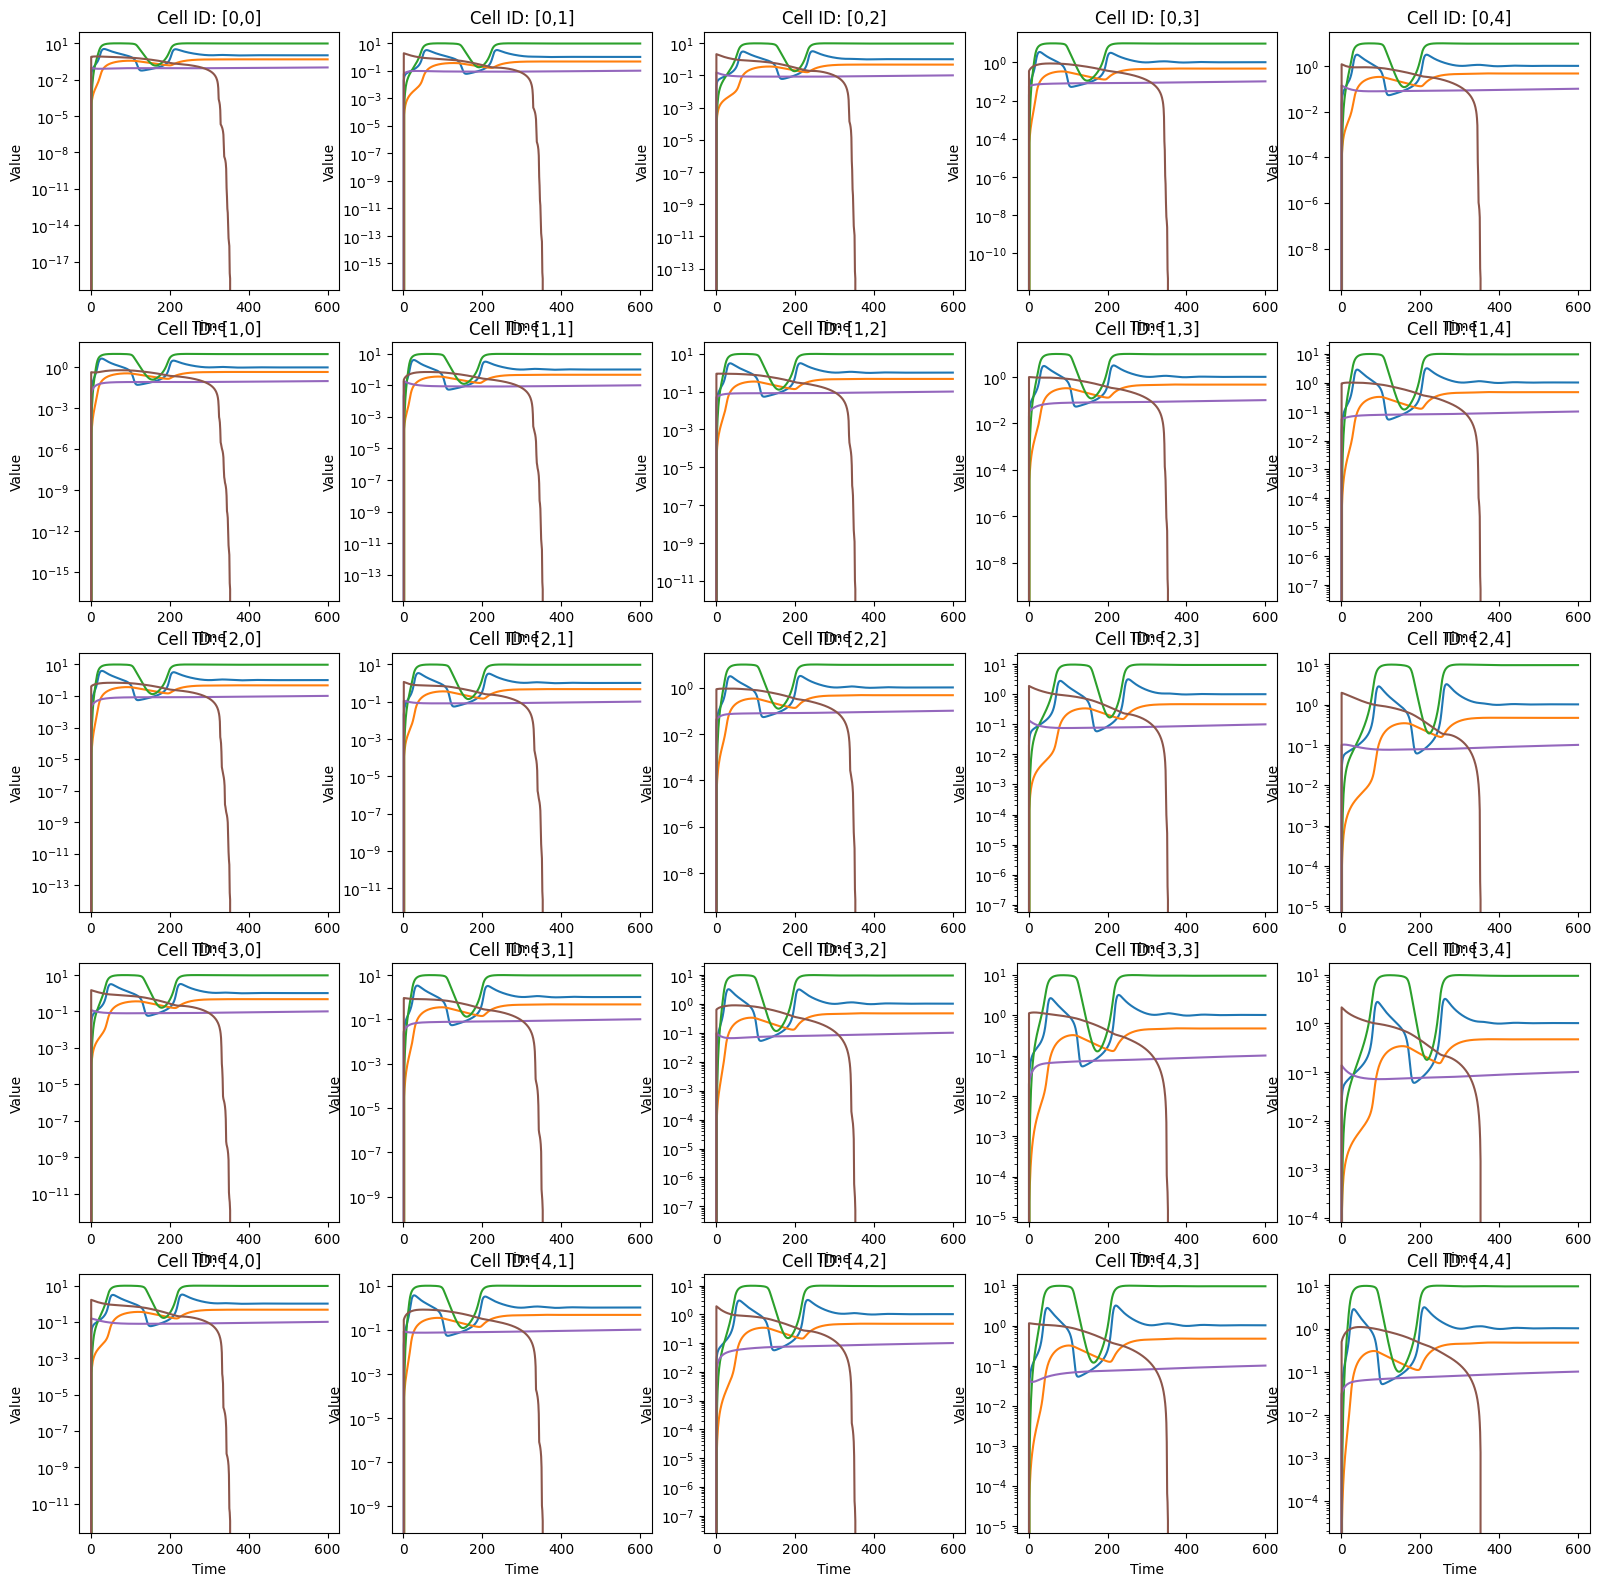

In [147]:
# plot results
results_fig = plot_simulation_data(
    data['cells'],
    num_rows=DEFAULT_BOUNDS[0],
    num_cols=DEFAULT_BOUNDS[1],
    filename=f'results_by_cell2'
)

Writing out/composite_fields_temporal2


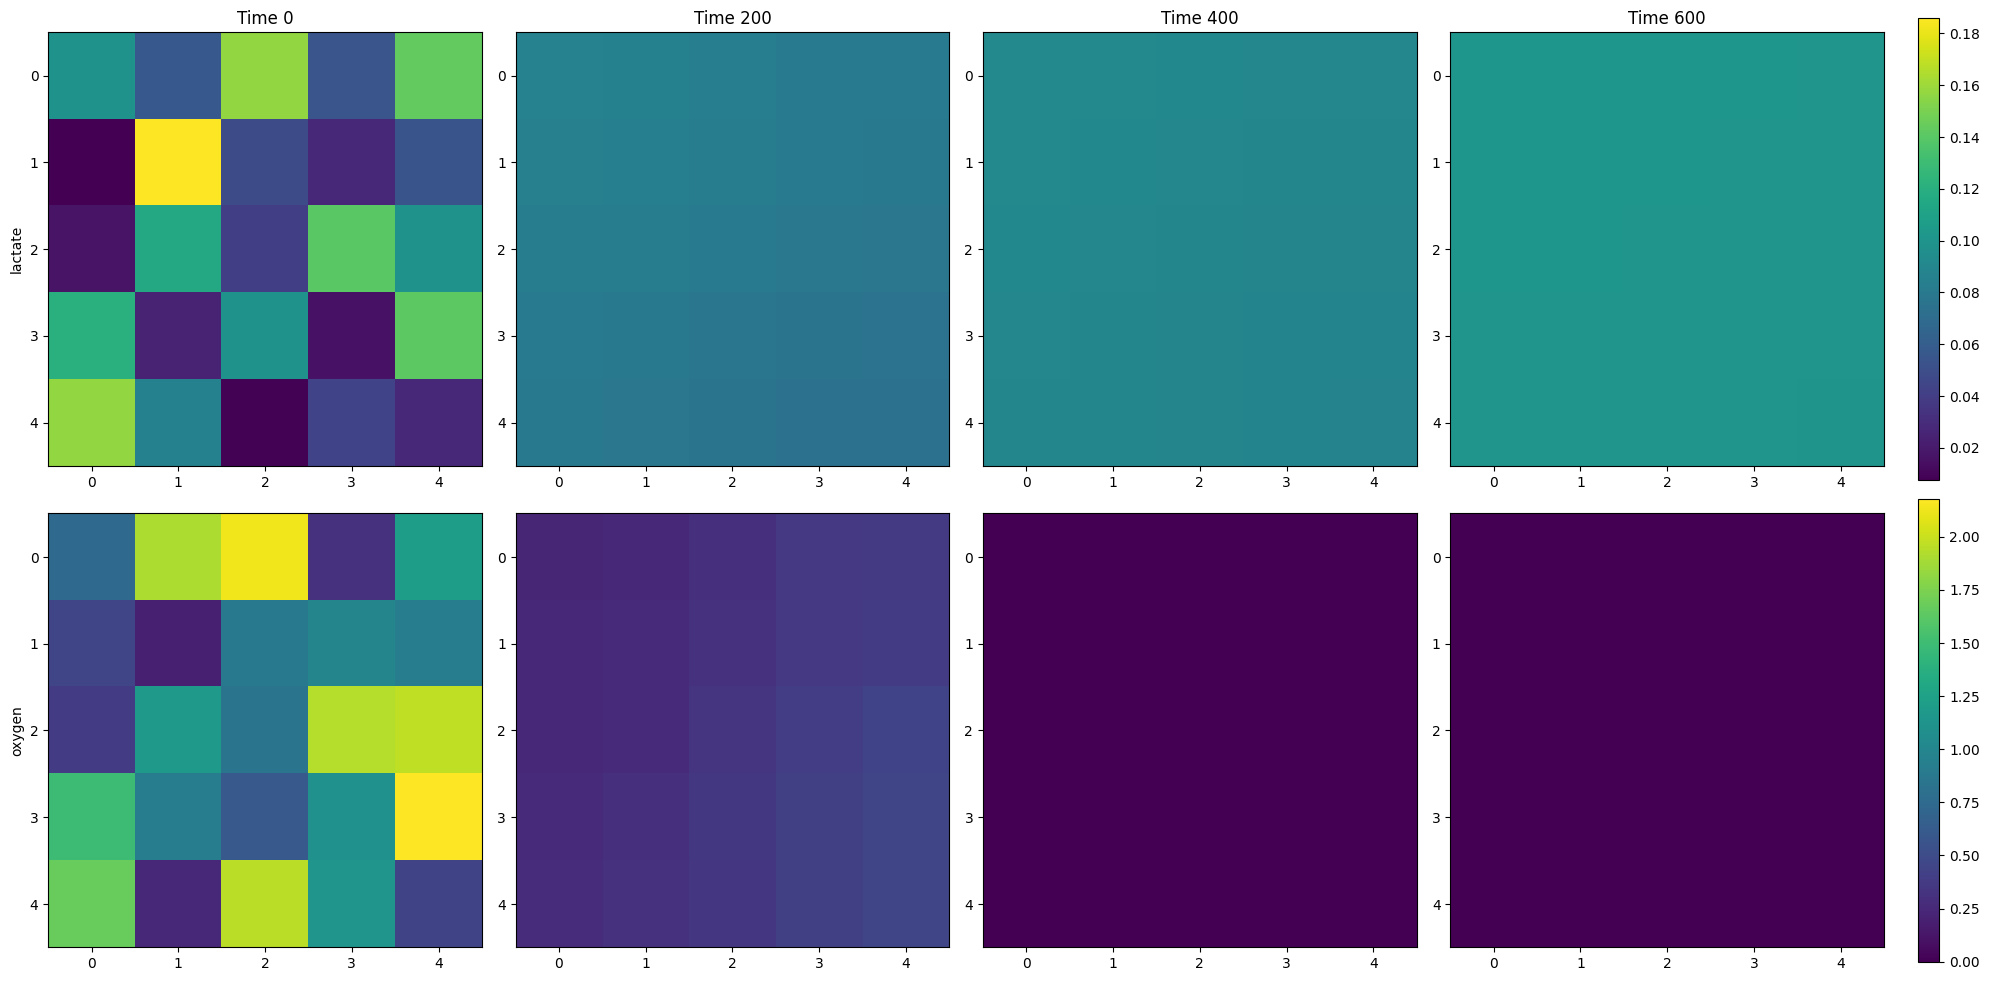

In [148]:
# plot fields
n_snapshots = 4
nth_timestep = int(total_time / (n_snapshots - 1))
temporal_fig = plot_fields_temporal(
    data['fields'],
    nth_timestep=nth_timestep,
    out_dir='out',
    filename=f'composite_fields_temporal2'
)